In [12]:
# Dependencies
import numpy as np
import glob
import pandas as pd
from pyvirtualdisplay import Display
import seaborn as sns
import warnings
import os
import logging
import imageio
import matplotlib as mpl
from matplotlib import pyplot as plt, patches
from utils.config import load_config_nb
from evaluation.policy_evaluation import evaluate_policy
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from IPython.display import HTML, Image

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (6, 6)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

mpl.rcParams['lines.markersize'] = 9

### Settings

In [13]:
MAX_FILES = 100
DETERMINISTIC = True 
SINGLE_AGENT_MODE = True
METRICS = ['goal_rate', 'off_road', 'veh_veh_collision']

VIDEO_PATH = '../evaluation/videos' 

### Configurations

In [14]:
# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
model_config = load_config_nb("model_config")

# Set data path
env_config.data_path = "../data_full/train/"
env_config.val_data_path = "../data_full/valid/"
env_config.num_files = MAX_FILES

# Convert to single agent env
if SINGLE_AGENT_MODE:
    env_config.max_num_vehicles = 1

# Logging level set to INFO
LOGGING_LEVEL = "CRITICAL"

# Scenes on which to evaluate the models
# Make sure file order is fixed so that we evaluate on the same files used for training
train_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
train_eval_files = sorted([os.path.basename(file) for file in train_file_paths])[:MAX_FILES]

# Test
test_file_paths = glob.glob(f"{env_config.val_data_path}" + "/tfrecord*")
test_eval_files = sorted([os.path.basename(file) for file in test_file_paths])[:MAX_FILES]

# Behavioral cloning model path
BC_BASE_PATH = f"../models/il/"

# Logging
logger = logging.getLogger()
logging.basicConfig(format="%(message)s")
logger.setLevel(LOGGING_LEVEL)

## 1. Establish baseline performance

### 1.1 What is the performance of expert replay? | Step env **using positions**

In [6]:
df_expert_replay = evaluate_policy(
    env_config=env_config,
    mode='expert_replay',
    data_path='../data_new/train_no_tl/',
    select_from_k_scenes=1000,
    controlled_agents=100,
    num_episodes=100,
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


In [8]:
df_expert_replay[METRICS].mean() * 100

goal_rate            47.227191
off_road              1.788909
veh_veh_collision     0.536673
dtype: float64

### 1.2 What is the performance of expert replay? | Step env using **continuous actions**

In [10]:
df_cont_act_expert_replay = evaluate_policy(
    env_config=env_config,
    data_path='../data_new/train_no_tl/',
    controlled_agents=1,
    mode='cont_act_expert_replay',
    select_from_k_scenes=1000,
    num_episodes=100,
)

100%|██████████| 100/100 [00:04<00:00, 20.56it/s]


In [11]:
df_cont_act_expert_replay[METRICS].mean() * 100

goal_rate            31.0
off_road             16.0
veh_veh_collision     6.0
dtype: float64

### 1.3 What is the performance of the discretized expert replay? | Step env using **discrete actions**

In [4]:
# Uncomment this to change the action space
# env_config.accel_discretization = 1001
# env_config.accel_lower_bound = -200
# env_config.accel_upper_bound = 200
# env_config.steering_lower_bound = -np.pi # steer right
# env_config.steering_upper_bound = np.pi # steer left
# env_config.steering_discretization = 1001

In [11]:
df_disc_expert_replay = evaluate_policy(
    env_config=env_config,
    mode='disc_expert_act_replay',
    data_path,
    select_from_k_scenes=100,
    num_episodes=100,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:49<00:00, 20.29it/s]


In [13]:
df_disc_expert_replay[METRICS].mean() * 100

goal_rate            48.1
off_road             18.4
veh_veh_collision     8.5
dtype: object

### 1.3.1 What causes this gap in performance for the discretized expert replay?

- `None` actions (gaps in the trajectory)
- `nan` steering wheel actions ()

In [5]:
def step_through_scene(env, scene_name, use_expert_actions, use_av_only=True, max_steps=80, verbose=False):
    
    pos_arr = np.zeros((max_steps, 2))
    speed_arr = np.zeros((max_steps))
    steering_arr = np.zeros(max_steps)
    action_acc = np.zeros(max_steps)
    action_ste = np.zeros(max_steps)

    # RESET
    obs_dict = env.reset(filename=scene_name, use_av_only=use_av_only)
    
    # TAKE VEHICLE
    veh_obj = env.controlled_vehicles[0]
    print(f'Controlling veh_id: {veh_obj.id}, is_av: {veh_obj.is_av} | init_speed: {veh_obj.speed}')

    for time_step in range(max_steps):
        
        action_dict = {}
        if use_expert_actions:
            expert_action = env.scenario.expert_action(veh_obj, time_step)
            action_dict[veh_obj.id] = expert_action
        else:   
            veh_obj.expert_control = True   
            expert_action = env.scenario.expert_action(veh_obj, time_step)
            
        if expert_action is not None:
            action_acc[time_step] = expert_action.acceleration
            action_ste[time_step] = expert_action.steering
        speed_arr[time_step] = veh_obj.speed
        pos_arr[time_step, 0] = veh_obj.position.x
        pos_arr[time_step, 1] = veh_obj.position.y
        steering_arr[time_step] = veh_obj.steering
    
        if use_expert_actions and expert_action is None:
            print(f'expert_action is None at time_step: {time_step}')
            continue 
        
        # Step
        obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
        
        #print(f't = {time_step} | v_t+1 = {veh_obj.speed}')
        
        if done_dict['__all__']:
            print(f' \n Done at {time_step} | goal_achieved: {info_dict[veh_obj.id]["goal_achieved"]} | veh_edge_collision: {info_dict[veh_obj.id]["veh_edge_collision"]} | veh_veh_collision: {info_dict[veh_obj.id]["veh_veh_collision"]}\n')
            break
        
    return veh_obj, time_step, pos_arr, speed_arr, steering_arr, action_acc, action_ste

In [6]:
# Make env
#scene_name = "tfrecord-00000-of-01000_175.json" # Velocity is 1 always m/s
#scene_name = "tfrecord-00000-of-01000_26.json"
#scene_name = 'tfrecord-00000-of-01000_14.json' # another example
#scene_name = "tfrecord-00000-of-01000_369.json"
#scene_name = "tfrecord-00000-of-01000_17.json"
scene_name = "tfrecord-00000-of-01000_29.json"
env_config.data_path = "../data_new/train_no_tl/"

env = BaseEnv(env_config)

In [8]:
# Step through scene in expert mode
veh_obj, t_done, pos, speed, steering, _, _ = step_through_scene(
    env=env, scene_name=scene_name, use_expert_actions=False, use_av_only=True,
)

# Step through scene USING EXPERT ACTIONS
veh_obj, t_done_exp, pos_exp, speed_exp, steering_exp, action_acc_exp, action_ste_exp = step_through_scene(
    env=env, scene_name=scene_name, use_expert_actions=True, use_av_only=True, verbose=False
)

KeyError: 36

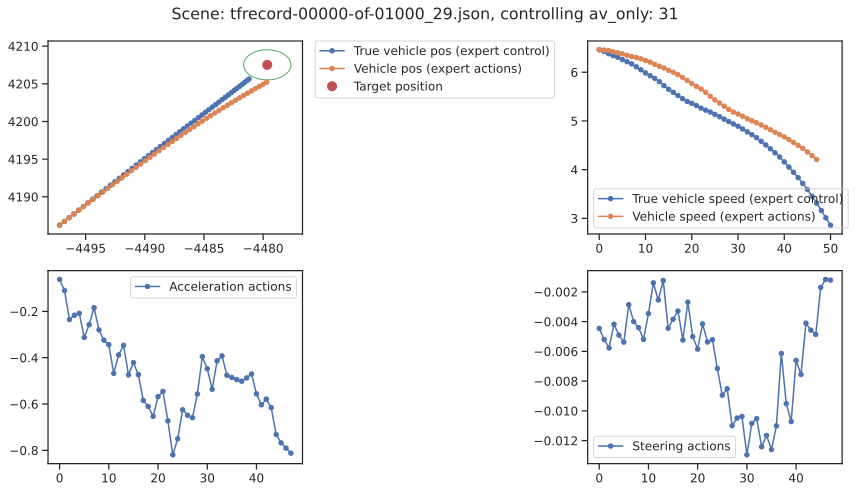

In [102]:
def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, color=color, fill=False)
    ax.add_patch(circle)

# Create a 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
fig.suptitle(f'Scene: {scene_name}, controlling av_only: {veh_obj.id}')

# Your existing code for plotting vehicle positions and target position
axs[0, 0].plot(pos[:t_done, 0], pos[:t_done, 1], '.-', label='True vehicle pos (expert control)')
axs[0, 0].plot(pos_exp[:t_done_exp, 0], pos_exp[:t_done_exp, 1], '.-', label='Vehicle pos (expert actions)')
axs[0, 0].plot(veh_obj.target_position.x, veh_obj.target_position.y, 'ro', label='Target position')
target_position = (veh_obj.target_position.x, veh_obj.target_position.y)
radius = 2
plot_circle(axs[0, 0], target_position, radius, 'g')
axs[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Plot speed
axs[0, 1].plot(speed[:t_done], '.-', label='True vehicle speed (expert control)')
axs[0, 1].plot(speed_exp[:t_done_exp], '.-', label='Vehicle speed (expert actions)')
axs[0, 1].legend()

# Plot acceleration
axs[1, 0].plot(action_acc_exp[:t_done_exp], '.-', label='Acceleration actions')
axs[1, 0].legend()

# Plot steering
axs[1, 1].plot(action_ste_exp[:t_done_exp], '.-', label='Steering actions')
axs[1, 1].legend()

# Set titles and labels
plt.tight_layout()

### 1.4 What is the performance of the BC policy?

- BC model trained to 0.983 % accuracy
- No correction

In [5]:
# # Load trained human reference policy
# BC_MODEL = 'human_policy_S100_01_20_11_22'

# human_policy = load_policy(
#     data_path=BC_BASE_PATH,
#     file_name=BC_MODEL, 
# )

# df_expert_replay = evaluate_policy(
#     env_config=env_config,
#     policy=human_policy,
#     mode='policy',
#     num_scenes=100,
#     max_iters=500,
# )